In [ ]:
# prompt: connect to my drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


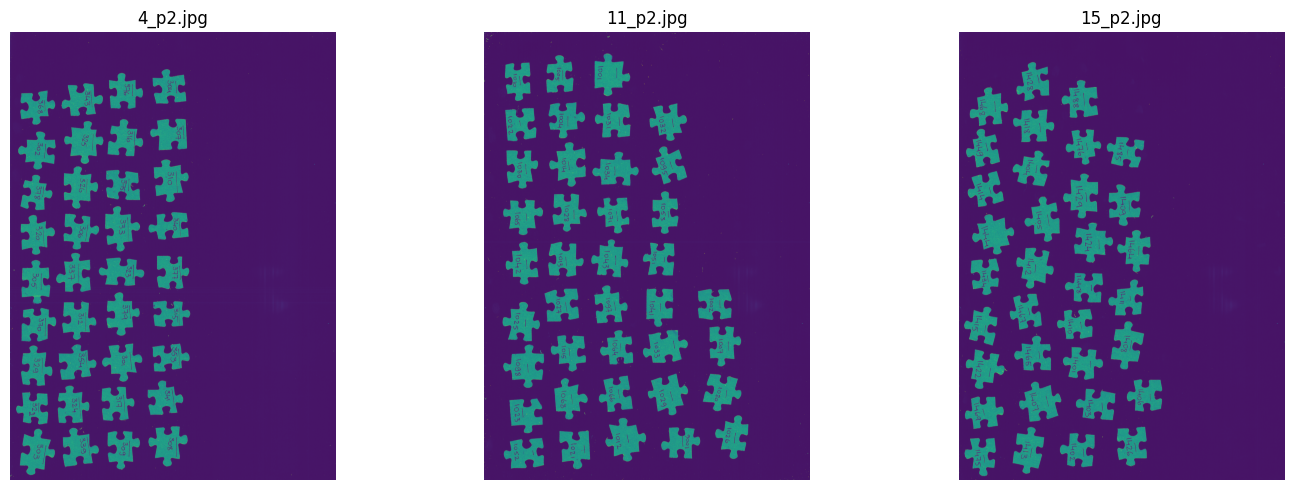

In [ ]:
# prompt: Extract the images from the zipped folder at /content/drive/MyDrive/Puzzle/archive.zip and display 3 of the images

import zipfile
import os
from PIL import Image
import matplotlib.pyplot as plt
import random

# Define the path to the zip file
zip_path = '/content/drive/MyDrive/Puzzle/archive.zip'
# Define the directory to extract the images to
extract_path = '/content/drive/MyDrive/Puzzle/extracted_images'

# Create the extraction directory if it doesn't exist
os.makedirs(extract_path, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
  zip_ref.extractall(extract_path)

# List all extracted files and filter for image files
image_files = [f for f in os.listdir(extract_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

# Display 3 images if available
if len(image_files) > 0:
  # Randomly select up to 3 images
  num_images_to_display = min(3, len(image_files))
  selected_images = random.sample(image_files, num_images_to_display)

  plt.figure(figsize=(15, 5))
  for i, image_name in enumerate(selected_images):
    image_path = os.path.join(extract_path, image_name)
    try:
      img = Image.open(image_path)
      plt.subplot(1, num_images_to_display, i + 1)
      plt.imshow(img)
      plt.title(image_name)
      plt.axis('off')
    except Exception as e:
      print(f"Could not open or display image {image_name}: {e}")

  plt.tight_layout()
  plt.show()
else:
  print("No image files found in the extracted folder.")

In [ ]:
!pip install opencv-python

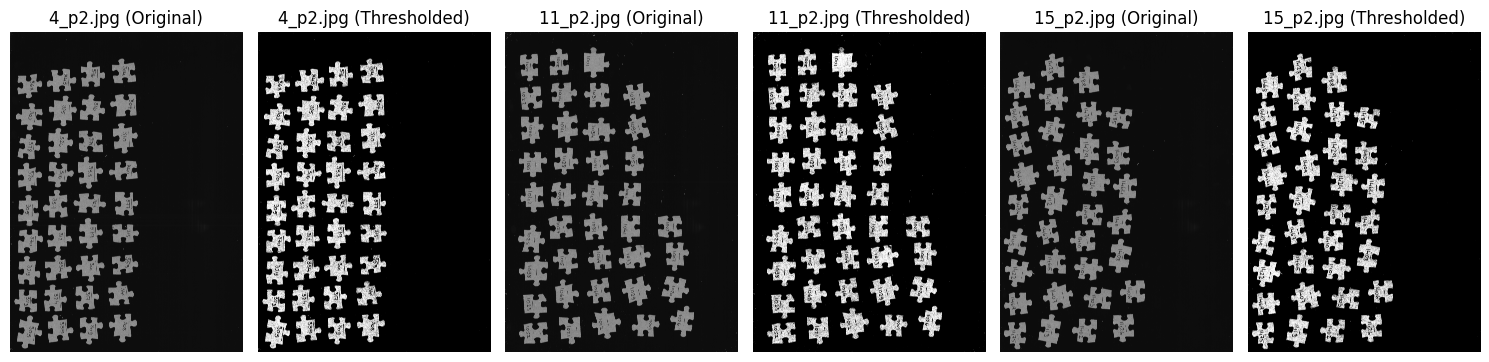

In [ ]:
# prompt: Create a function for thresholding on each of the images that I can adjust, The create another function to show the images

import cv2
import numpy as np

def apply_threshold(image_path, threshold_value):
  """Applies a simple threshold to an image.

  Args:
    image_path: The path to the image file.
    threshold_value: The threshold value (0-255).

  Returns:
    A NumPy array representing the thresholded image, or None if an error occurs.
  """
  try:
    # Open the image
    img = Image.open(image_path).convert('L') # Convert to grayscale
    img_np = np.array(img)

    # Apply threshold
    _, thresholded_img = cv2.threshold(img_np, threshold_value, 255, cv2.THRESH_BINARY)
    return thresholded_img
  except Exception as e:
    print(f"Error applying threshold to image {image_path}: {e}")
    return None

def show_images(images, titles=None):
  """Displays a list of images using matplotlib.

  Args:
    images: A list of NumPy arrays representing the images.
    titles: An optional list of titles for the images.
  """
  num_images = len(images)
  plt.figure(figsize=(15, 5 * ((num_images + 2) // 3))) # Adjust figure size based on number of images
  for i, img in enumerate(images):
    if img is not None:
      plt.subplot(1, num_images, i + 1)
      plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None) # Use gray colormap for grayscale
      if titles and i < len(titles):
        plt.title(titles[i])
      plt.axis('off')
  plt.tight_layout()
  plt.show()

# Example usage:
# Assuming 'selected_images' is a list of image filenames from the previous code

# Define a threshold value (adjust as needed)
threshold = 128

thresholded_images = []
image_titles = []

for image_name in selected_images:
  image_path = os.path.join(extract_path, image_name)
  thresholded_img = apply_threshold(image_path, threshold)
  if thresholded_img is not None:
    thresholded_images.append(thresholded_img)
    image_titles.append(f'{image_name} (Thresholded)')

# Display the original and thresholded images side by side (optional)
# For demonstration, let's also load the original images to display next to thresholded
original_images_to_show = []
for image_name in selected_images:
    image_path = os.path.join(extract_path, image_name)
    try:
        img = Image.open(image_path)
        original_images_to_show.append(np.array(img))
    except Exception as e:
        print(f"Could not load original image {image_name}: {e}")
        original_images_to_show.append(None)

# Combine original and thresholded images and their titles for display
all_images = []
all_titles = []
for i in range(len(selected_images)):
    if original_images_to_show[i] is not None:
        all_images.append(original_images_to_show[i])
        all_titles.append(selected_images[i] + ' (Original)')
    if thresholded_images and i < len(thresholded_images): # Check if thresholded_images is not empty and index is valid
        all_images.append(thresholded_images[i])
        all_titles.append(selected_images[i] + ' (Thresholded)')


if all_images:
    show_images(all_images, all_titles)
elif thresholded_images: # If original images failed to load but thresholded are available
    show_images(thresholded_images, image_titles)
else:
    print("No images to display.")

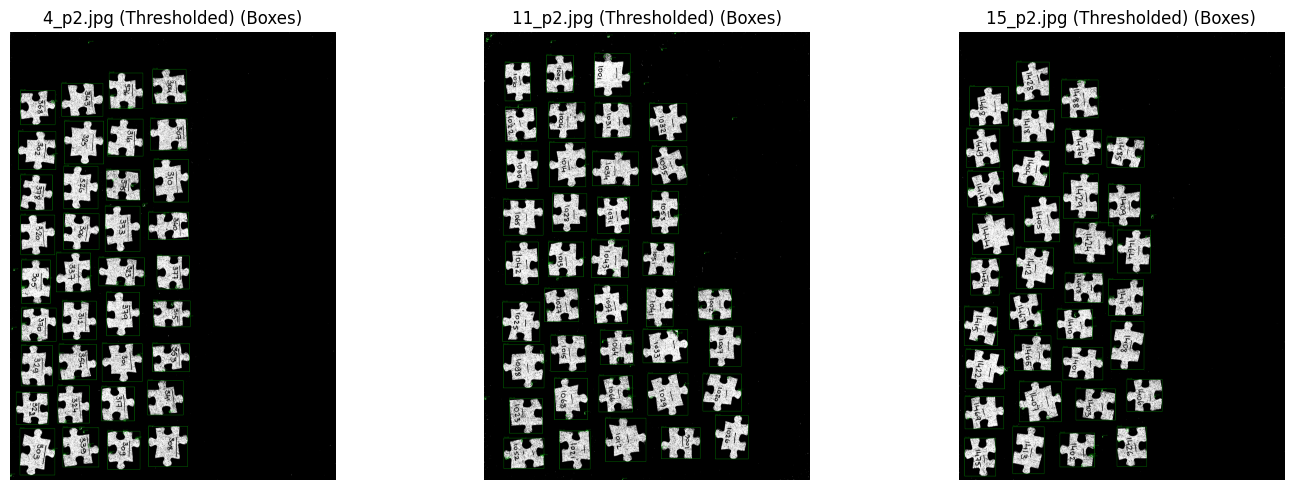

Number of pieces in image 1: 90
Number of pieces in image 2: 124
Number of pieces in image 3: 90


In [ ]:
# prompt: Create a function that will create a single bounding box around each piece using the contours of the threshold images. There will not be any bounding boxes within a bounding box, display the images with the bounding box and create a unique identifier for each piece

import cv2
import numpy as np
from PIL import Image # Import Image from PIL again to ensure it's available in this cell
import matplotlib.pyplot as plt # Import matplotlib again

def find_and_draw_bounding_boxes(thresholded_images):
    """
    Finds contours and draws a single bounding box around each piece
    in the thresholded images. Assigns a unique identifier to each piece.

    Args:
        thresholded_images: A list of NumPy arrays representing thresholded images.

    Returns:
        A tuple containing:
        - A list of images with bounding boxes drawn, or None if input is empty.
        - A list of piece counts for each image.
    """
    if not thresholded_images:
        print("No thresholded images provided.")
        return None, []

    images_with_boxes = []
    piece_counts_per_image = [] # List to store the piece count for each image
    cumulative_piece_counter = 0 # Keep a cumulative counter for unique IDs

    for i, thresholded_img in enumerate(thresholded_images):
        if thresholded_img is None:
            images_with_boxes.append(None)
            piece_counts_per_image.append(0) # Add 0 count for skipped images
            continue

        # Ensure the image is in the correct format for findContours (CV_8UC1)
        img_8u = thresholded_img.astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(img_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a color version of the image to draw color boxes and text
        img_with_box = cv2.cvtColor(img_8u, cv2.COLOR_GRAY2BGR)

        current_image_piece_count = 0 # Counter for the current image

        # Iterate through the contours and draw bounding boxes
        for contour in contours:
            # Get the bounding box for the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Filter small contours which might be noise
            if w > 10 and h > 10: # Adjust these values based on your image size and noise
                # Draw the bounding box
                cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2) # Green color, thickness 2

                # Assign a unique identifier
                cumulative_piece_counter += 1
                piece_id = f"Piece_{cumulative_piece_counter:03d}" # e.g., Piece_001

                # Put the unique identifier text near the bounding box
                cv2.putText(img_with_box, piece_id, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1) # Green text
                current_image_piece_count += 1 # Increment piece count for the current image

        images_with_boxes.append(img_with_box)
        piece_counts_per_image.append(current_image_piece_count) # Store the count for this image

    return images_with_boxes, piece_counts_per_image

# Example usage:
# Assuming 'thresholded_images' is a list of thresholded images from the previous code

images_with_bounding_boxes, piece_counts = find_and_draw_bounding_boxes(thresholded_images)

if images_with_bounding_boxes:
    # Create titles for the images with bounding boxes
    # Ensure image_titles is accessible or re-created if needed
    # Assuming image_titles was defined in a previous cell and is available in global scope
    try:
        box_titles = [f'{title} (Boxes)' for title in image_titles]
    except NameError:
        # If image_titles is not defined, create a placeholder
        box_titles = [f'Image {i+1} (Boxes)' for i in range(len(images_with_bounding_boxes))]


    # Display the images with bounding boxes
    show_images(images_with_bounding_boxes, box_titles)

    # Print the number of pieces that are in each image
    for i, count in enumerate(piece_counts):
        print(f"Number of pieces in image {i + 1}: {count}")

else:
    print("No images with bounding boxes to display.")

Streaming output truncated to the last 5000 lines.
  Contour 955: x=2564, y=5279, w=1, h=1
    -> Rejected (w=1, h=1)
  Contour 956: x=2107, y=5279, w=1, h=2
    -> Rejected (w=1, h=2)
  Contour 957: x=2103, y=5279, w=1, h=1
    -> Rejected (w=1, h=1)
  Contour 958: x=1282, y=5279, w=1, h=1
    -> Rejected (w=1, h=1)
  Contour 959: x=1275, y=5279, w=11, h=7
    -> Rejected (w=11, h=7)
  Contour 960: x=1274, y=5278, w=2, h=2
    -> Rejected (w=2, h=2)
  Contour 961: x=2576, y=5277, w=1, h=1
    -> Rejected (w=1, h=1)
  Contour 962: x=1153, y=5277, w=1, h=1
    -> Rejected (w=1, h=1)
  Contour 963: x=2606, y=5276, w=1, h=1
    -> Rejected (w=1, h=1)
  Contour 964: x=2595, y=5276, w=3, h=3
    -> Rejected (w=3, h=3)
  Contour 965: x=2563, y=5276, w=1, h=1
    -> Rejected (w=1, h=1)
  Contour 966: x=2578, y=5275, w=2, h=2
    -> Rejected (w=2, h=2)
  Contour 967: x=2598, y=5274, w=2, h=1
    -> Rejected (w=2, h=1)
  Contour 968: x=2581, y=5274, w=5, h=3
    -> Rejected (w=5, h=3)
  Contour

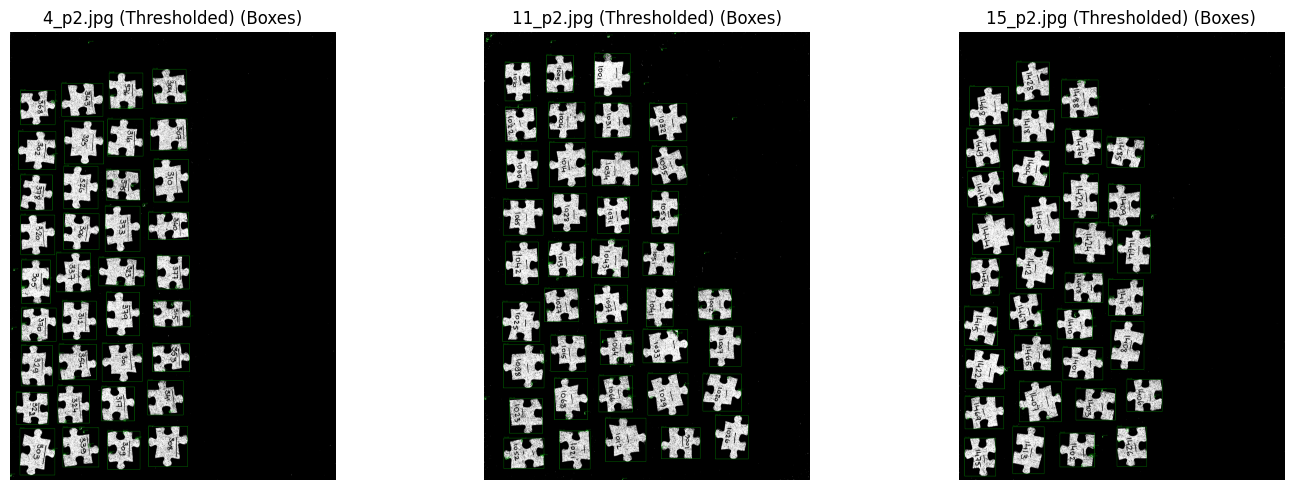


Displaying Images with All Detected Contours:


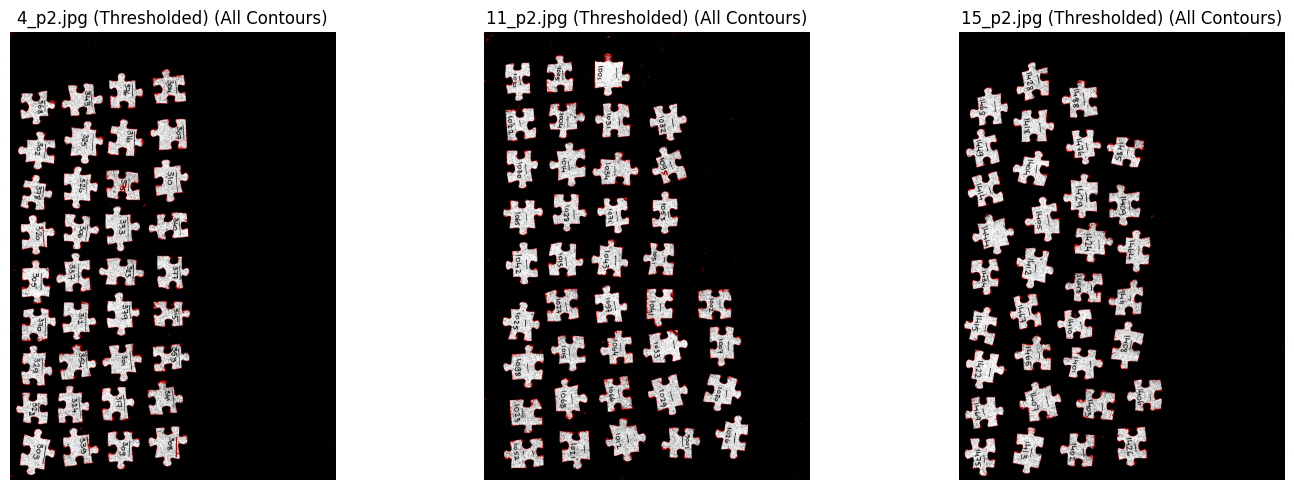


Piece Counts:
Number of pieces in 4_p2.jpg: 90
Number of pieces in 11_p2.jpg: 124
Number of pieces in 15_p2.jpg: 90


In [ ]:
# prompt: Create a function that will create a single bounding box around each piece using the contours of the threshold images. There will not be any bounding boxes within a bounding box, display the images with the bounding box and create a unique identifier for each piece

import cv2
import numpy as np
from PIL import Image # Import Image from PIL again to ensure it's available in this cell
import matplotlib.pyplot as plt # Import matplotlib again

def apply_threshold(image_path, threshold_value):
  """Applies a simple threshold to an image.

  Args:
    image_path: The path to the image file.
    threshold_value: The threshold value (0-255).

  Returns:
    A NumPy array representing the thresholded image, or None if an error occurs.
  """
  try:
    # Open the image
    img = Image.open(image_path).convert('L') # Convert to grayscale
    img_np = np.array(img)

    # Apply threshold
    _, thresholded_img = cv2.threshold(img_np, threshold_value, 255, cv2.THRESH_BINARY)
    return thresholded_img
  except Exception as e:
    print(f"Error applying threshold to image {image_path}: {e}")
    return None

def show_images(images, titles=None):
  """Displays a list of images using matplotlib.

  Args:
    images: A list of NumPy arrays representing the images.
    titles: An optional list of titles for the images.
  """
  num_images = len(images)
  # Adjust figure size based on number of images, aiming for roughly 3 images per row
  rows = (num_images + 2) // 3
  plt.figure(figsize=(15, 5 * rows))
  for i, img in enumerate(images):
    if img is not None:
      plt.subplot(rows, min(num_images, 3), i + 1) # Adjust subplot layout
      # Check if the image is color (3 channels) or grayscale (2 dimensions)
      if len(img.shape) == 3:
          # Convert BGR (OpenCV default) to RGB for Matplotlib display
          plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      elif len(img.shape) == 2:
          plt.imshow(img, cmap='gray') # Use gray colormap for grayscale
      else:
          # Handle other potential image formats if necessary
           plt.imshow(img)


      if titles and i < len(titles):
        plt.title(titles[i])
      plt.axis('off')
  plt.tight_layout()
  plt.show()


def find_and_draw_bounding_boxes(thresholded_images):
    """
    Finds contours and draws a single bounding box around each piece
    in the thresholded images. Assigns a unique identifier to each piece.

    Args:
        thresholded_images: A list of NumPy arrays representing thresholded images.

    Returns:
        A tuple containing:
        - A list of images with bounding boxes drawn, or None if input is empty.
        - A list of piece counts for each image.
        - A list of images with contours drawn for debugging (optional).
    """
    if not thresholded_images:
        print("No thresholded images provided.")
        return None, [], None

    images_with_boxes = []
    piece_counts_per_image = [] # List to store the piece count for each image
    cumulative_piece_counter = 0 # Keep a cumulative counter for unique IDs
    images_with_contours_drawn = [] # List to store images with contours drawn for debugging

    for i, thresholded_img in enumerate(thresholded_images):
        if thresholded_img is None:
            images_with_boxes.append(None)
            piece_counts_per_image.append(0) # Add 0 count for skipped images
            images_with_contours_drawn.append(None)
            continue

        # Ensure the image is in the correct format for findContours (CV_8UC1)
        img_8u = thresholded_img.astype(np.uint8)

        # Find contours
        contours, _ = cv2.findContours(img_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Create a color version of the image to draw color boxes and text
        img_with_box = cv2.cvtColor(img_8u, cv2.COLOR_GRAY2BGR)

        # Create a color version to draw all contours for debugging
        img_with_contours = cv2.cvtColor(img_8u, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(img_with_contours, contours, -1, (0, 0, 255), 2) # Draw all contours in blue

        current_image_piece_count = 0 # Counter for the current image

        # Iterate through the contours and draw bounding boxes
        print(f"\nProcessing image {i+1}. Found {len(contours)} initial contours.")
        for j, contour in enumerate(contours):
            # Get the bounding box for the contour
            x, y, w, h = cv2.boundingRect(contour)

            # Print contour dimensions for debugging
            print(f"  Contour {j+1}: x={x}, y={y}, w={w}, h={h}")

            # Filter small contours which might be noise
            if w > 10 and h > 10: # Adjust these values based on your image size and noise
                print(f"    -> Accepted (w={w}, h={h})")
                # Draw the bounding box
                cv2.rectangle(img_with_box, (x, y), (x + w, y + h), (0, 255, 0), 2) # Green color, thickness 2

                # Assign a unique identifier
                cumulative_piece_counter += 1
                piece_id = f"Piece_{cumulative_piece_counter:03d}" # e.g., Piece_001

                # Put the unique identifier text near the bounding box
                cv2.putText(img_with_box, piece_id, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1) # Green text
                current_image_piece_count += 1 # Increment piece count for the current image
            else:
                 print(f"    -> Rejected (w={w}, h={h})")


        images_with_boxes.append(img_with_box)
        piece_counts_per_image.append(current_image_piece_count) # Store the count for this image
        images_with_contours_drawn.append(img_with_contours)


    return images_with_boxes, piece_counts_per_image, images_with_contours_drawn

# Example usage:
# Assuming 'thresholded_images' is a list of thresholded images from the previous code

images_with_bounding_boxes, piece_counts, images_with_all_contours = find_and_draw_bounding_boxes(thresholded_images)

if images_with_bounding_boxes:
    # Create titles for the images with bounding boxes
    # Ensure image_titles is accessible or re-created if needed
    # Assuming image_titles was defined in a previous cell and is available in global scope
    try:
        box_titles = [f'{title} (Boxes)' for title in image_titles]
        contour_titles = [f'{title} (All Contours)' for title in image_titles]
    except NameError:
        # If image_titles is not defined, create a placeholder
        box_titles = [f'Image {i+1} (Boxes)' for i in range(len(images_with_bounding_boxes))]
        contour_titles = [f'Image {i+1} (All Contours)' for i in range(len(images_with_bounding_boxes))]


    # Display the images with bounding boxes
    print("\nDisplaying Images with Bounding Boxes:")
    show_images(images_with_bounding_boxes, box_titles)

    # Optionally display images with all contours drawn for debugging
    print("\nDisplaying Images with All Detected Contours:")
    show_images(images_with_all_contours, contour_titles)


    # Print the number of pieces that are in each image
    print("\nPiece Counts:")
    for i, count in enumerate(piece_counts):
        # Use original image name if available, otherwise default
        try:
            img_name = image_titles[i].replace(' (Thresholded)', '') # Get original name from thresholded title
        except (NameError, IndexError):
             img_name = f'Image {i + 1}'

        print(f"Number of pieces in {img_name}: {count}")

else:
    print("No images with bounding boxes to display.")

Processing image: /content/drive/MyDrive/Puzzle/extracted_images/4_p2.jpg
Found 33610 initial contours for 4_p2.jpg.
Detected 0 pieces in 4_p2.jpg.


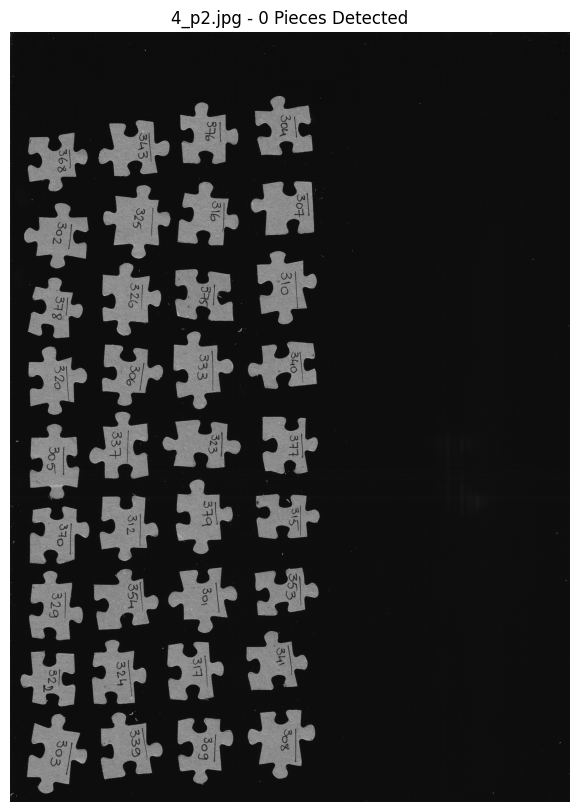

In [ ]:
# prompt: Display one image with a number for each piece counted displayed on top of the piece

def display_image_with_numbered_pieces(image_path, threshold_value=128):
    """
    Loads an image, applies thresholding, finds contours, draws bounding boxes,
    numbers each piece, and displays the image.

    Args:
        image_path: The path to the image file.
        threshold_value: The threshold value (0-255) for binary thresholding.
    """
    print(f"Processing image: {image_path}")

    # 1. Load and threshold the image
    thresholded_img = apply_threshold(image_path, threshold_value)

    if thresholded_img is None:
        print(f"Skipping {image_path} due to thresholding error.")
        return

    # Ensure the image is in the correct format for findContours (CV_8UC1)
    img_8u = thresholded_img.astype(np.uint8)

    # 2. Find contours
    # Use cv2.RETR_EXTERNAL to retrieve only the extreme outer contours.
    contours, _ = cv2.findContours(img_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 3. Create a color version of the image to draw on
    # Load the original color image to draw on for better visualization
    try:
        original_img = Image.open(image_path).convert('RGB') # Convert to RGB
        img_to_display = np.array(original_img)
        # Convert RGB (PIL default) to BGR (OpenCV default) if you want to use OpenCV drawing functions directly
        img_to_display = cv2.cvtColor(img_to_display, cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"Could not load original image {image_path} for drawing: {e}. Drawing on thresholded image.")
        img_to_display = cv2.cvtColor(img_8u, cv2.COLOR_GRAY2BGR)


    piece_count = 0

    # 4. Iterate through the contours, filter, draw bounding boxes, and add numbers
    print(f"Found {len(contours)} initial contours for {os.path.basename(image_path)}.")
    for j, contour in enumerate(contours):
        # Get the bounding box for the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Filter small contours which might be noise
        # These values might need tuning based on your dataset
        min_width = 100
        min_height = 100

        if w > min_width and h > min_height:
            piece_count += 1

            # Draw the bounding box (Green color, thickness 2)
            cv2.rectangle(img_to_display, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Put the piece number on top of the piece (approximately centered horizontally)
            text = str(piece_count)
            font = cv2.FONT_HERSHEY_SIMPLEX
            font_scale = 1
            font_thickness = 2

            # Get text size to position it
            (text_width, text_height), baseline = cv2.getTextSize(text, font, font_scale, font_thickness)

            # Calculate text position (center horizontally, slightly above the top edge of the box)
            text_x = x + (w - text_width) // 2
            text_y = y + text_height + 5 # Add a small offset below the top edge

            # Ensure text is not out of bounds if drawing very close to the top of the image
            if text_y < text_height + 5:
                text_y = y + h // 2 # As a fallback, try centering vertically if too close to top

            # Draw the text (White color)
            cv2.putText(img_to_display, text, (text_x, text_y), font, font_scale, (255, 255, 255), font_thickness, cv2.LINE_AA)

    print(f"Detected {piece_count} pieces in {os.path.basename(image_path)}.")

    # 5. Display the image
    plt.figure(figsize=(10, 10))
    # Convert BGR back to RGB for Matplotlib display
    plt.imshow(cv2.cvtColor(img_to_display, cv2.COLOR_BGR2RGB))
    plt.title(f'{os.path.basename(image_path)} - {piece_count} Pieces Detected')
    plt.axis('off')
    plt.show()


# --- Usage Example ---

# Assuming 'selected_images' and 'extract_path' are available from previous cells
# Select one image to display
if len(selected_images) > 0:
    # Choose the first selected image for this demonstration
    image_to_process_name = selected_images[0]
    image_to_process_path = os.path.join(extract_path, image_to_process_name)

    # Define a threshold value (adjust as needed for your image)
    threshold_value = 200 # Example value

    # Call the function to display the image with numbered pieces
    display_image_with_numbered_pieces(image_to_process_path, threshold_value)
else:
    print("No images were previously selected or found.")


In [ ]:
# prompt: Cut out each piece and create an individual image with that piece and put it into a newly created folder

import cv2
import numpy as np
from PIL import Image # Import Image from PIL again to ensure it's available in this cell
import matplotlib.pyplot as plt # Import matplotlib again
import os # Import os module again

def apply_threshold(image_path, threshold_value):
  """Applies a simple threshold to an image.

  Args:
    image_path: The path to the image file.
    threshold_value: The threshold value (0-255).

  Returns:
    A NumPy array representing the thresholded image, or None if an error occurs.
  """
  try:
    # Open the image
    img = Image.open(image_path).convert('L') # Convert to grayscale
    img_np = np.array(img)

    # Apply threshold
    _, thresholded_img = cv2.threshold(img_np, threshold_value, 255, cv2.THRESH_BINARY)
    return thresholded_img
  except Exception as e:
    print(f"Error applying threshold to image {image_path}: {e}")
    return None


def cut_and_save_pieces(image_path, threshold_value=128, output_folder='/content/drive/MyDrive/Puzzle/puzzle_individual_pieces'):
    """
    Loads an image, applies thresholding, finds contours, cuts out each piece,
    and saves each piece as a separate image in a new folder.

    Args:
        image_path: The path to the original image file.
        threshold_value: The threshold value (0-255) for binary thresholding.
        output_folder: The path to the folder where individual piece images will be saved.

    Returns:
        The number of pieces cut and saved from the current image.
    """
    print(f"Processing image for cutting: {image_path}")

    # 1. Load the original color image
    try:
        original_img = Image.open(image_path).convert('RGB') # Convert to RGB
        original_img_np = np.array(original_img)
        # Convert RGB (PIL default) to BGR (OpenCV default)
        original_img_np_bgr = cv2.cvtColor(original_img_np, cv2.COLOR_RGB2BGR)
    except Exception as e:
        print(f"Could not load original image {image_path}: {e}. Skipping cutting.")
        return 0 # Return 0 pieces if image loading fails

    # 2. Apply thresholding to find contours
    thresholded_img = apply_threshold(image_path, threshold_value)

    if thresholded_img is None:
        print(f"Skipping cutting for {image_path} due to thresholding error.")
        return 0 # Return 0 pieces if thresholding fails

    # Ensure the image is in the correct format for findContours (CV_8UC1)
    img_8u = thresholded_img.astype(np.uint8)

    # 3. Find contours
    contours, _ = cv2.findContours(img_8u, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 4. Create the output folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)
    print(f"Output folder created/checked: {output_folder}")


    piece_count = 0

    # 5. Iterate through the contours, filter, cut out the piece, and save
    print(f"Found {len(contours)} initial contours for cutting {os.path.basename(image_path)}.")
    for j, contour in enumerate(contours):
        # Get the bounding box for the contour
        x, y, w, h = cv2.boundingRect(contour)

        # Filter small contours (adjust these values based on your image size and noise)
        min_width = 120
        min_height = 120

        if w > min_width and h > min_height:
            piece_count += 1

            # Cut out the piece using the bounding box coordinates from the original color image
            # Ensure coordinates are within the image bounds
            x1, y1, x2, y2 = max(0, x), max(0, y), min(original_img_np_bgr.shape[1], x + w), min(original_img_np_bgr.shape[0], y + h)

            if x2 > x1 and y2 > y1: # Ensure valid bounding box
                piece_image = original_img_np_bgr[y1:y2, x1:x2]

                # Define the filename for the individual piece
                image_name_base = os.path.splitext(os.path.basename(image_path))[0]
                piece_filename = f"{image_name_base}_piece_{piece_count:03d}.png"
                piece_filepath = os.path.join(output_folder, piece_filename)

                # Save the piece image
                cv2.imwrite(piece_filepath, piece_image)
                print(f"  Saved piece {piece_count}: {piece_filepath}")
            else:
                print(f"  Skipping piece {piece_count} due to invalid bounding box dimensions.")


    print(f"Finished cutting and saving {piece_count} pieces from {os.path.basename(image_path)}.")
    return piece_count # Return the count of pieces for this image




# --- Usage Example ---

# Assuming 'selected_images' and 'extract_path' are available from previous cells
# Define the output folder for the individual pieces
output_pieces_folder = '/content/drive/MyDrive/Puzzle/puzzle_individual_pieces'

#Set selected_images to all the images in /content/drive/MyDrive/Puzzle/extracted_images
selected_images = os.listdir(extract_path)

total_pieces_saved = 0 # Initialize a counter for the total number of pieces

# Process each selected image to cut out and save the pieces
if len(selected_images) > 0:
    # Define a threshold value (adjust as needed for your images)
    threshold_value = 120 # Example value

    for image_name in selected_images:
        image_path = os.path.join(extract_path, image_name)
        # Call the function and add the returned piece count to the total
        pieces_in_current_image = cut_and_save_pieces(image_path, threshold_value, output_pieces_folder)
        total_pieces_saved += pieces_in_current_image


    # Optional: List the files in the output folder to verify
    print(f"\nFiles saved in {output_pieces_folder}:")
    !ls {output_pieces_folder}

else:
    print("No images were previously selected or found to cut.")

#Print the total number of pieces that were saved
print(f"Total pieces saved: {total_pieces_saved}")

Processing image for cutting: /content/drive/MyDrive/Puzzle/extracted_images/14_p2.jpg
Output folder created/checked: /content/drive/MyDrive/Puzzle/puzzle_individual_pieces
Found 2302 initial contours for cutting 14_p2.jpg.
  Saved piece 1: /content/drive/MyDrive/Puzzle/puzzle_individual_pieces/14_p2_piece_001.png
  Saved piece 2: /content/drive/MyDrive/Puzzle/puzzle_individual_pieces/14_p2_piece_002.png
  Saved piece 3: /content/drive/MyDrive/Puzzle/puzzle_individual_pieces/14_p2_piece_003.png
  Saved piece 4: /content/drive/MyDrive/Puzzle/puzzle_individual_pieces/14_p2_piece_004.png
  Saved piece 5: /content/drive/MyDrive/Puzzle/puzzle_individual_pieces/14_p2_piece_005.png
  Saved piece 6: /content/drive/MyDrive/Puzzle/puzzle_individual_pieces/14_p2_piece_006.png
  Saved piece 7: /content/drive/MyDrive/Puzzle/puzzle_individual_pieces/14_p2_piece_007.png
  Saved piece 8: /content/drive/MyDrive/Puzzle/puzzle_individual_pieces/14_p2_piece_008.png
  Saved piece 9: /content/drive/MyDrive/

In [ ]:
pip install label-studio


In [ ]:
label-studio start .\puz_lab

SyntaxError: unexpected character after line continuation character (<ipython-input-15-5fb7814a593c>, line 1)

In [ ]:
label-studio

NameError: name 'label' is not defined